## DeepExplain - Inception V3 for natural image classification
### Comparison of classic and adversarially trained models for Tensorflow-Slim Inception V3

In [26]:
import efficientnet_builder
from sklearn import metrics

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
from imageio import imread
import tensorflow.compat.v1 as tf
# from tensorflow.contrib.slim.nets import inception

    
from deepexplain.tfDeep import DeepExplain

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Define aux function to import images in batches
def load_images():
    images = np.zeros((8, 299, 299, 3))
    filenames = []
    idx = 0
    for filepath in tf.gfile.Glob(os.path.join('/home/kathy/mnt/data/processed_data/frames_small_format/test_data', '*.jpg')):
        with tf.gfile.Open(filepath,'rb') as f:
            image = imread(f, pilmode='RGB').astype(np.float) / 255.0
        # Images for inception classifier are normalized to be in [-1, 1] interval.
        images[idx, :, :, :] = image * 2.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
    return filenames, images

In [22]:
from tensorflow.python.framework import ops

# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
num_classes = 4

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = '/home/kathy/mnt/data/checkpoint_files/efficientnet-b0-4-classes/archive/model.ckpt-1000'

ops.reset_default_graph()

sess = tf.Session()

model_name = 'efficientnet-b0'

MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=sess.graph) as de:
    sess.run(tf.global_variables_initializer())

    latest = tf.train.latest_checkpoint('/home/kathy/mnt/data/checkpoint_files/efficientnet-b0-4-classes/archive')
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    filenames, xs = load_images()
 
    X -= tf.constant(
      MEAN_RGB, shape=[1, 1, 3], dtype=X.dtype)
    X /= tf.constant(
      STDDEV_RGB, shape=[1, 1, 3], dtype=X.dtype)

    logits, endpoints = efficientnet_builder.build_model(X, 'efficientnet-b0', False)

    yi = tf.argmax(logits, 1)
    tf.train.get_or_create_global_step()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('/home/kathy/mnt/data/checkpoint_files/efficientnet-b0-4-classes/archive/model.ckpt-1000.meta')
    saver.restore(sess, latest)
    
    predictions = sess.run(yi, feed_dict={X: xs})
   

INFO:tensorflow:Restoring parameters from /home/kathy/mnt/data/checkpoint_files/efficientnet-b0-4-classes/archive/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /home/kathy/mnt/data/checkpoint_files/efficientnet-b0-4-classes/archive/model.ckpt-1000


[0 0 0 0 0 0 0 0]
(<tf.Tensor 'accuracy/value:0' shape=() dtype=float32>, <tf.Tensor 'accuracy/update_op:0' shape=() dtype=float32>)


In [27]:
labels = [3, 3, 0, 0, 0, 1, 2, 2]
top_1_accuracy = accuracy_score(labels, predictions)
print(predictions)
print(top_1_accuracy)


NameError: name 'accuracy_score' is not defined

In [15]:
# Compute attributions for the classified images
# Every DeepExplain method must be called in a DeepExplain context.
# In this case, we use two different contexts to create the model and to 
# run the explanation methods. This works as long as the same session is provided.

with DeepExplain(session=sess) as de:
    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        'Saliency maps':        de.explain('saliency', tf.reduce_max(logits, 1), X, xs),
        'Gradient * Input':     de.explain('grad*input', tf.reduce_max(logits, 1), X, xs),
        'Integrated Gradients': de.explain('intgrad', tf.reduce_max(logits, 1), X, xs),
        'Epsilon-LRP':          de.explain('elrp', tf.reduce_max(logits, 1), X, xs),
#         'DeepLIFT (Rescale)':   de.explain('deeplift', tf.reduce_max(logits, 1), X, xs),
        # Perturbation-based (comment out to evaluate, but this will take a while!)
        # 'Occlusion [15x15]':    de.explain('occlusion', tf.reduce_max(logits, 1), X, xs, window_shape=(15,15,3), step=4)
    }
    print ("Done!")

Done!


[0 0 0 0 0 0 0 0]


/home/kathy/mnt/data/models/DeepExplain/examples/examples_utils.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
  cmap_xi.set_bad(alpha=0)


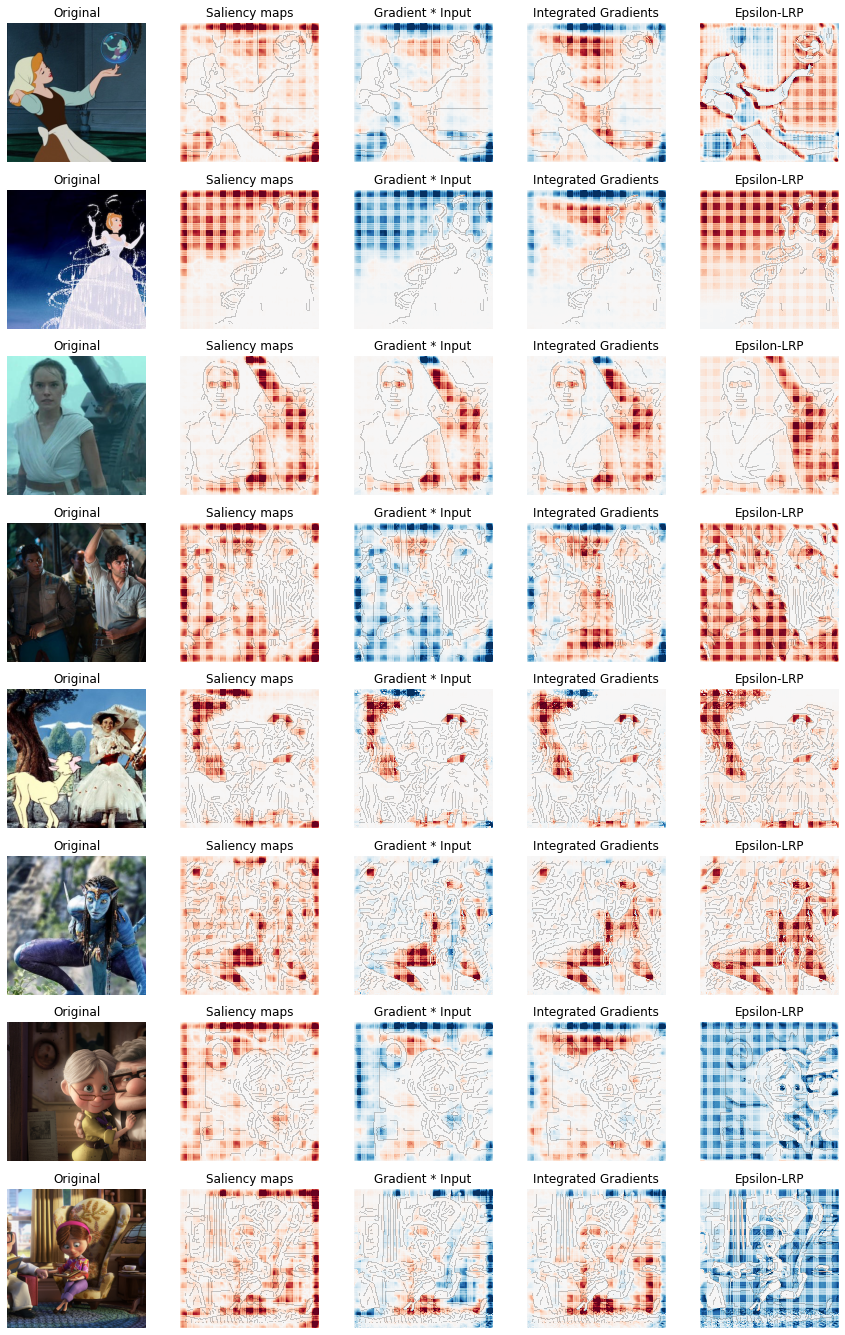

In [16]:
# Plot attributions
from examples_utils import plot, plt
%matplotlib inline

n_cols = int(len(attributions)) + 1
n_rows = len(xs) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
print(labels)
for i, xi in enumerate(xs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, a in enumerate(attributions):
        axj = axes.flatten()[i*n_cols + j + 1]
        plot(attributions[a][i], xi = xi, axis=axj, dilation=.5, percentile=99, alpha=.2).set_title(a)